In [1]:
"""
Name: con_fitting.ipynb
Authors: Christian
Example of fitting simulation to data
"""
%load_ext autoreload
%autoreload 2

In [2]:
 # General imports
import logging
logging.basicConfig(level="WARN")
import cProfile, pstats, io
from pstats import SortKey

import pyabc    
from pyabc.sampler import DaskDistributedSampler
import numpy as np
import matplotlib.pyplot as plt
import sys
import scipy
import os
import tempfile
from tqdm import tqdm
import pandas as pd
from time import time
# Adding path to module
# picture path
PICS = '../pics/'
# Module imports
from contagion import Contagion, config
import contagion
from contagion.config import ConfigClass, _baseconfig




In [3]:
data_np = np.load("../data/cities/munich_march.npy")

data_sane = np.zeros(np.max(data_np[0]))
data_sane[data_np[0]-1] = data_np[1]

data = {"is_infected": data_sane}

In [4]:
my_config = {
    "simulation length": 100,
    "population size": 10000
}

contagion = Contagion(userconfig=my_config)
contagion.sim()


In [5]:
#fields = ["is_infected", "is_dead", "is_recovered"]

fields = ["is_dead", "is_hospitalized"]
data = {field: np.asarray(contagion.statistics[field]) for field in fields}

In [6]:
def autocorr(x, t=1):
    return np.corrcoef([x[:-t], x[t:]])[0, 1]

def model(parameters):
    this_config = dict(my_config)
    for key, val in parameters.items():
        key = key.replace("_", " ")
        this_config[key] = val
    this_config["re-use population"] = True
    contagion = Contagion(userconfig=this_config)
    contagion.sim()
    
    return contagion.statistics


def make_sum_stats(fields):

    def gen_summary_stats(simulation):
        sum_stats = {}
        
        for field in fields:
            sum_stats[field+"_xmax_diff"] = np.argmax(np.diff(simulation[field]))
            sum_stats[field+"_ymax_diff"] = np.max(np.diff(simulation[field]))
            sum_stats[field+"_xmin_diff"] = np.argmin(np.diff(simulation[field]))
            sum_stats[field+"_ymin_diff"] = np.min(np.diff(simulation[field]))
            sum_stats[field+"_xmax"] = np.argmax(simulation[field])
            sum_stats[field+"_ymax"] = np.max(simulation[field])
            sum_stats[field+"_avg_growth_rate"] = np.average(np.diff(simulation[field]))
            sum_stats[field+"_val_end"] = simulation[field][-1]
                                   
        return sum_stats
    return gen_summary_stats

sum_stat_func = make_sum_stats(fields)
    
distance = pyabc.AdaptivePNormDistance(
    p=2, scale_function=pyabc.distance.root_mean_square_deviation)

#distance = pyabc.AggregatedDistance([distance0, distance1])
prior = pyabc.Distribution(
    {"infectious duration mean": pyabc.RV("uniform", 1, 10),
     "incubation duration mean": pyabc.RV("uniform", 1, 10),     
      "mortality rate mean":  pyabc.RV("uniform", 0.05, 0.5)
    })

In [7]:
"""
def plot_model(pars, fields):
    stats = model(pars)
    for field, dist in zip(fields, distance.distances):
        plt.plot(stats[field], ".", label="{}, dist: {}".format(field, dist(stats, data)))
        

plot_model({"infectious_duration_mean": 10}, ["is_infected", "is_dead", "is_recovered"])
plot_model({"infectious_duration_mean": 3}, ["is_infected", "is_dead", "is_recovered"])
plt.legend()
"""

'\ndef plot_model(pars, fields):\n    stats = model(pars)\n    for field, dist in zip(fields, distance.distances):\n        plt.plot(stats[field], ".", label="{}, dist: {}".format(field, dist(stats, data)))\n        \n\nplot_model({"infectious_duration_mean": 10}, ["is_infected", "is_dead", "is_recovered"])\nplot_model({"infectious_duration_mean": 3}, ["is_infected", "is_dead", "is_recovered"])\nplt.legend()\n'

In [8]:
from dask.distributed import Client

client = Client("tcp://10.152.133.30:46571")
client

Client Scheduler: tcp://10.152.133.30:46571 Dashboard: http://10.152.133.30:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [9]:
sampler = pyabc.sampler.MulticoreEvalParallelSampler(n_procs=10)
#sampler = DaskDistributedSampler(client, batch_size=1, client_max_jobs=400)
population=pyabc.populationstrategy.AdaptivePopulationSize(10, max_population_size=20,
                                                          mean_cv=0.1, n_bootstrap=5)
epsilon = pyabc.epsilon.QuantileEpsilon()
abc = pyabc.ABCSMC(model, prior, distance, population_size=population, sampler=sampler,                 
                   acceptor = pyabc.UniformAcceptor(use_complete_history=True),
                   summary_statistics=sum_stat_func,
                   eps=epsilon
                   )
db_path = "sqlite:///" + os.path.join("/scratch4/chaack/", "abc.db")

In [10]:
logging.getLogger().setLevel("INFO")

In [11]:
abc.new(db_path, sum_stat_func(data))
history1 = abc.run(max_nr_populations=2)


INFO:History:Start <ABCSMC(id=115, start_time=2020-04-08 12:08:58.181047, end_time=None)>
INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 11.320647254655498
INFO:ABC:t: 0, eps: 11.320647254655498.
INFO:ABC:Acceptance rate: 10 / 39 = 2.5641e-01, ESS=1.0000e+01.
INFO:Adaptation:Change nr particles 10 -> 20
INFO:ABC:t: 1, eps: 10.127376558973896.
INFO:ABC:Acceptance rate: 20 / 141 = 1.4184e-01, ESS=1.3418e+01.
INFO:Adaptation:Change nr particles 20 -> 20
INFO:History:Done <ABCSMC(id=115, start_time=2020-04-08 12:08:58.181047, end_time=2020-04-08 12:10:39.769380)>


In [16]:
np.random.multivariate_normal([0],np.eye(1), size=None)

array([-0.33792546])

In [12]:
history1 = abc.load(db_path, 97)

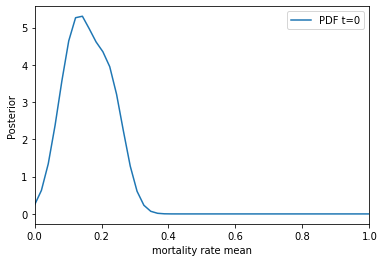

In [13]:
fig, ax = plt.subplots()
for t in range(0, history1.max_t+1):
    df, w = history1.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_1d(
        df, w,
        xmin=0, xmax=1,
        x="mortality rate mean", ax=ax,
        label="PDF t={}".format(t))
#ax.axvline(data["is_infected"], color="k", linestyle="dashed");
#plt.ylim(0, 0.2)
plt.legend()

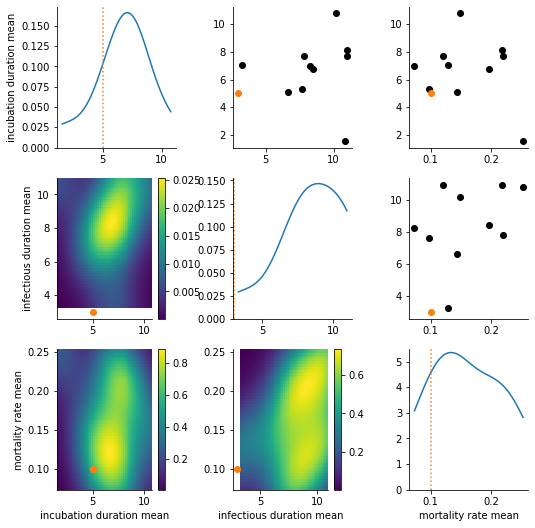

In [14]:
pyabc.visualization.plot_kde_matrix_highlevel(history1, refval =_baseconfig)
plt.savefig(PICS+"/abc_testrun.png", dpi=150)

In [ ]:
pyabc.visualization.plot_sample_numbers_trajectory(history1)

In [ ]:
pyabc.visualization.plot_acceptance_rates_trajectory(history1)

In [27]:
x = np.atleast_3d(np.ones((50, 3)))
x_m = np.ones((16, 3))

cov = np.eye(3)
print(cov.shape)
scipy.stats.multivariate_normal.pdf(np.swapaxes(x-x_m.T, 1,2), cov=cov).sum(axis=1)

(3, 3)


array([1.01589817, 1.01589817, 1.01589817, 1.01589817, 1.01589817,
       1.01589817, 1.01589817, 1.01589817, 1.01589817, 1.01589817,
       1.01589817, 1.01589817, 1.01589817, 1.01589817, 1.01589817,
       1.01589817, 1.01589817, 1.01589817, 1.01589817, 1.01589817,
       1.01589817, 1.01589817, 1.01589817, 1.01589817, 1.01589817,
       1.01589817, 1.01589817, 1.01589817, 1.01589817, 1.01589817,
       1.01589817, 1.01589817, 1.01589817, 1.01589817, 1.01589817,
       1.01589817, 1.01589817, 1.01589817, 1.01589817, 1.01589817,
       1.01589817, 1.01589817, 1.01589817, 1.01589817, 1.01589817,
       1.01589817, 1.01589817, 1.01589817, 1.01589817, 1.01589817])

In [29]:

scipy.stats.multivariate_normal.pdf(np.swapaxes(x-x_m.T, 1,2), cov=cov).sum(axis=1)
print(np.array([(scipy.stats.multivariate_normal.pdf(xs.squeeze() - x_m, cov=cov)).sum()
      for xs in x]))


[1.01589817 1.01589817 1.01589817 1.01589817 1.01589817 1.01589817
 1.01589817 1.01589817 1.01589817 1.01589817 1.01589817 1.01589817
 1.01589817 1.01589817 1.01589817 1.01589817 1.01589817 1.01589817
 1.01589817 1.01589817 1.01589817 1.01589817 1.01589817 1.01589817
 1.01589817 1.01589817 1.01589817 1.01589817 1.01589817 1.01589817
 1.01589817 1.01589817 1.01589817 1.01589817 1.01589817 1.01589817
 1.01589817 1.01589817 1.01589817 1.01589817 1.01589817 1.01589817
 1.01589817 1.01589817 1.01589817 1.01589817 1.01589817 1.01589817
 1.01589817 1.01589817]


In [32]:
for xs in x:
    print(scipy.stats.multivariate_normal.pdf(xs - x_m, cov=np.eye(1)))
    

[0.39894228 0.39894228 0.39894228 0.39894228 0.39894228 0.39894228
 0.39894228 0.39894228 0.39894228 0.39894228 0.39894228 0.39894228
 0.39894228 0.39894228 0.39894228 0.39894228 0.39894228 0.39894228
 0.39894228 0.39894228 0.39894228 0.39894228 0.39894228 0.39894228
 0.39894228 0.39894228 0.39894228 0.39894228 0.39894228 0.39894228
 0.39894228 0.39894228 0.39894228 0.39894228 0.39894228 0.39894228
 0.39894228 0.39894228 0.39894228 0.39894228 0.39894228 0.39894228
 0.39894228 0.39894228 0.39894228 0.39894228 0.39894228 0.39894228
 0.39894228 0.39894228 0.39894228 0.39894228 0.39894228 0.39894228
 0.39894228 0.39894228 0.39894228 0.39894228 0.39894228 0.39894228
 0.39894228 0.39894228 0.39894228 0.39894228 0.39894228 0.39894228
 0.39894228 0.39894228 0.39894228 0.39894228 0.39894228 0.39894228
 0.39894228 0.39894228 0.39894228 0.39894228 0.39894228 0.39894228
 0.39894228 0.39894228 0.39894228 0.39894228 0.39894228 0.39894228
 0.39894228 0.39894228 0.39894228 0.39894228 0.39894228 0.3989

In [28]:
print(scipy.stats.multivariate_normal.pdf(x[0]-x_m, cov=cov))

1.520593620757152e-80


In [22]:
scipy.stats.multivariate_normal.pdf(x, mean=x_m, cov=cov)

array([1.52059362e-80, 1.52059362e-80, 1.52059362e-80, 1.52059362e-80,
       1.52059362e-80, 1.52059362e-80, 1.52059362e-80, 1.52059362e-80,
       1.52059362e-80, 1.52059362e-80, 1.52059362e-80, 1.52059362e-80,
       1.52059362e-80, 1.52059362e-80, 1.52059362e-80, 1.52059362e-80,
       1.52059362e-80, 1.52059362e-80, 1.52059362e-80, 1.52059362e-80,
       1.52059362e-80, 1.52059362e-80, 1.52059362e-80, 1.52059362e-80,
       1.52059362e-80, 1.52059362e-80, 1.52059362e-80, 1.52059362e-80,
       1.52059362e-80, 1.52059362e-80, 1.52059362e-80, 1.52059362e-80,
       1.52059362e-80, 1.52059362e-80, 1.52059362e-80, 1.52059362e-80,
       1.52059362e-80, 1.52059362e-80, 1.52059362e-80, 1.52059362e-80,
       1.52059362e-80, 1.52059362e-80, 1.52059362e-80, 1.52059362e-80,
       1.52059362e-80, 1.52059362e-80, 1.52059362e-80, 1.52059362e-80,
       1.52059362e-80, 1.52059362e-80])